# Разведочный анализ данных

Это задание посвящено изучению данных и построению различных визуализаций.  
Наша цель - провести **разведочный анализ данных**, чтобы исследовать поведение данных и выявить в них закономерности.

Мы будем работать с датассетом пассажиров [Титаника](https://en.wikipedia.org/wiki/Titanic).

Классическая задача, решаемая на этих данных: предсказать, выжил пассажир или нет по его характеристикам.  
То есть целевая переменная - столбец `Survived`.

Цели:
* познакомиться с библиотекой `seaborn`
* научиться делать различные визуализации
* заполнять пропуски в данных
* делать однофакторный анализ
* конструировать новые признаки

Бонус:
* придумаем свою модель на основе проведенного анализа и оценим ее качество.

## Подключение библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

Фиксируем `random_state` для воспроизводимости случайных значений.

In [2]:
RANDOM_STATE = 42

Загрузим данные.

In [3]:
Data = pd.read_csv(
    "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/titanik.csv",
    sep=";"
    )

**Описание признаков**

- `Survived` — выжил данный пассажир или нет (*0* для умерших, *1* для выживших)
- `Pclass` — класс пассажира (*1* — высший, *2* — средний, *3* — низший)
- `Name` — имя
- `Sex` — пол
- `Age` — возраст
- `SibSp` — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника
- `Parch` — количество родителей, детей (в том числе приемных) на борту титаника
- `Ticket` — номер билета
- `Fare` — плата за проезд
- `Cabin` — каюта
- `Embarked` — порт посадки (*C* — Шербур; *Q* — Квинстаун; *S* — Саутгемптон)

## Обзор данных

Посмотрим на *5* случайных объектов из датасета.

In [4]:
Data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
572,573,1,1,"Flynn; Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S
815,816,0,1,Fry; Mr. Richard,male,NaN,0,0,112058,0.0000,B102,S
592,593,0,3,Elsbury; Mr. William James,male,47.0,0,0,A/5 3902,7.2500,NaN,S
54,55,0,1,Ostby; Mr. Engelhart Cornelius,male,65.0,0,1,113509,61.9792,B30,C
130,131,0,3,Drazenoic; Mr. Jozef,male,33.0,0,0,349241,7.8958,NaN,C


Выведите на экран размеры таблицы *Data*.

**Вопрос:** сколько объектов в данных?

In [5]:
Data.shape

(891, 12)

## Обработка признаков и однофакторный анализ

На данном этапе:

1) Найдем признаки, у которых есть пропущенные значения и обработаем эти пропущенные значения

2) Переведём категориальные признаки в числовые

Выведем на экран основные числовые характеристики числовых столбцов.  
Это можно сделать при помощи функции `describe`.

In [6]:
Data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В строке *count* отображается количество непропущенных значений в каждом столбце.

Основные статистики можно посмотреть и по категориальным колонкам.  
Для этого в функцию `describe` нужно передать аргумент `include='object'`.

Сделайте это.

In [7]:
Data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,3,681,147,3
top,Dooley; Mr. Patrick,male,347082,G6,S
freq,1,574,7,4,644


**Вопрос:** в скольких категориальных колонках есть пропуски?

### Столбец Sex

В столбце пол (`Sex`) три различных значения. Посмотрим на них.

In [8]:
Data['Sex'].value_counts()

Sex
male       574
female     312
unknown      5
Name: count, dtype: int64

Удалим пассажиров неизвестного пола, так как их всего *5*.

In [9]:
Data = Data[Data['Sex'] != 'unknown']

Проверьте, что строки с неизвестным полом исчезли.

In [10]:
Data[Data['Sex'] == 'unknown'].shape

(0, 12)

Признак `Sex` является категориальным, то есть содержит нечисловые значения. Для работы большинства алгоритмов необходимо переводить категории в числа.

Закодировать значения столбца с двумя категориями можно следующим образом. Пусть в воображаемом столбце *animal* есть два значения: *cat* и *dog*. Их можно перевести в *0* и *1* при помощи функции `map`:

`Data['animal'] = Data['animal'].map({'cat' : 1, 'dog' : 0})`


По аналогии закодируйте столбец `Sex` (*male* - *1*, *female* - *0*).

In [11]:
Data['Sex'] = Data['Sex'].map({'male':1, 'female':0})

**Вопрос** посчитайте сумму значений в закодированном столбце `Sex`.

In [12]:
Data['Sex'].sum()

np.int64(574)

Посмотрим, как влияет пол на выживаемость.

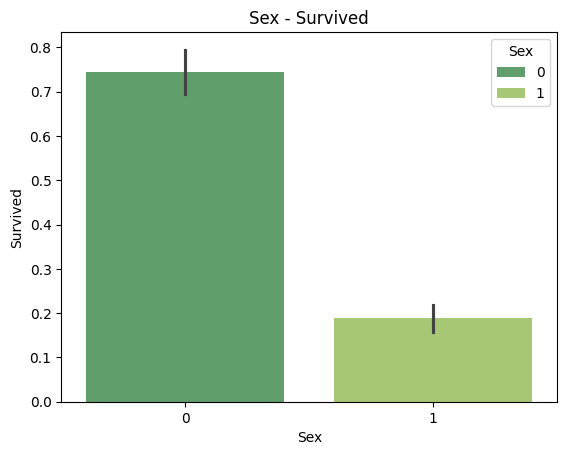

In [13]:
sns.barplot(x='Sex', y='Survived', data=Data, palette='summer', hue='Sex')
plt.title('Sex - Survived')
plt.show()

Гистограмму можно детализировать, добавив значение параметра `hue`.

### Столбец Pclass

Нарисуйте гистограмму выживаемости в зависимости от `Pclass`.  
Используйте `barplot`.

<Axes: xlabel='Pclass', ylabel='Survived'>

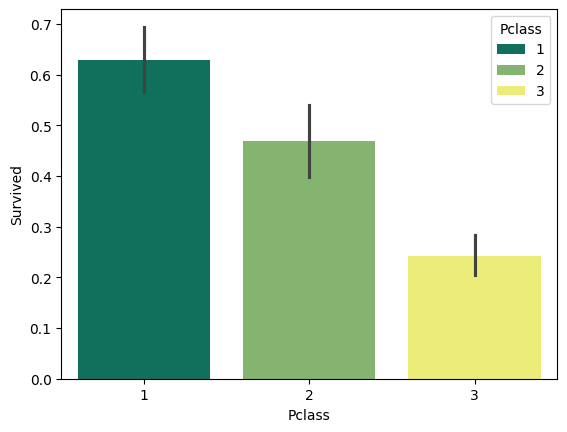

In [14]:
sns.barplot(x='Pclass', y='Survived', data=Data, palette='summer', hue='Pclass')

**Вопрос:** пассажиры из какого класса выживали чаще всего?

Посмотрим, как влияет пол человека и класс билета (`Pclass`) на выживаемость

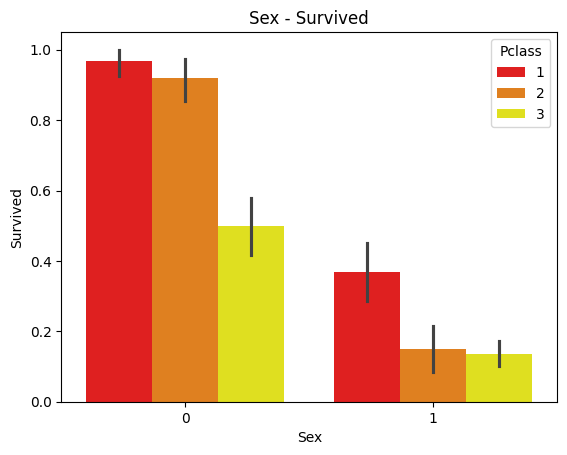

In [15]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=Data, palette='autumn')
plt.title('Sex - Survived')
plt.show();

### Столбец Embarked

**Вопрос** сколько различных значений принимает признак `Embarked`?

In [16]:
Data['Embarked'].nunique()

3

Пока что мы не обсуждали, как переводить в числа категориальные признаки с больше, чем двумя категориями.  
Поэтому давайте отбросим этот признак.

Сделайте это (вам пригодится метод [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)).

In [17]:
Data.drop('Embarked', inplace=True, axis=1)

### Столбец Age

Обработаем признак `Age`.

Мы помним, что в этом признаке много пропусков.

Заполним пропуски медианным значением `Age`.

In [18]:
median_age = Data['Age'].median()

Data['Age'].fillna(median_age, inplace=True)

C:\Users\kaban\AppData\Local\Temp\ipykernel_9476\971453984.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data['Age'].fillna(median_age, inplace=True)


Нарисуем распределение возраста пассажиров.

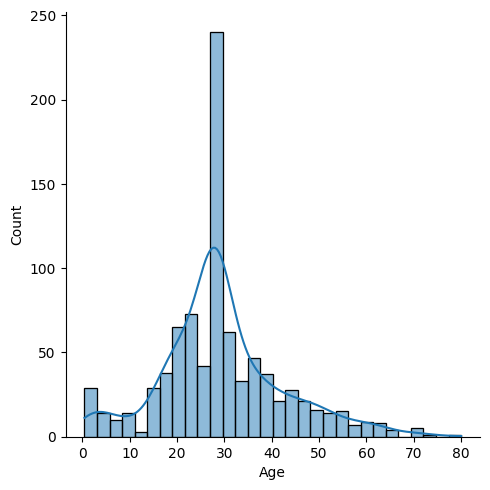

In [19]:
sns.displot(Data['Age'], kde=True)
plt.show()

### Другие столбцы

Удалите признак `Fare`. Он сильно связан с признаком `Pclass`, поэтому нам не нужен.

In [20]:
Data.drop('Fare', axis=1, inplace=True)
Data.shape

(886, 10)

**Вопрос:** сколько на данный момент колонок в таблице `Data`?

Столбец `PassengerId` является категориальным и не несёт важной информации, удалите его.

Столбцы `Ticket`, `Name` и `Cabin` в этот раз нам также не понадобятся. Удалите и их.

In [21]:
Data.drop(['PassengerId','Ticket','Name','Cabin'], axis=1, inplace=True)

После минимальной обработки данных у нас получилась следующая таблица:

In [22]:
Data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


## Исследование признаков

Нарисуйте матрицу корреляций столбцов между собой.

In [23]:
Data.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch
Survived,1.000000,-0.338447,-0.545547,-0.062245,-0.033743,0.085753
Pclass,-0.338447,1.000000,0.133972,-0.342216,0.083148,0.015606
Sex,-0.545547,0.133972,1.000000,0.081486,-0.114677,-0.259232
Age,-0.062245,-0.342216,0.081486,1.000000,-0.235465,-0.177241
SibSp,-0.033743,0.083148,-0.114677,-0.235465,1.000000,0.422104
Parch,0.085753,0.015606,-0.259232,-0.177241,0.422104,1.000000


**Вопрос:** какой столбец сильнее всего коррелирует с целевой переменной `Survived`?

Посмотрим на попарные зависимости некоторых признаков.

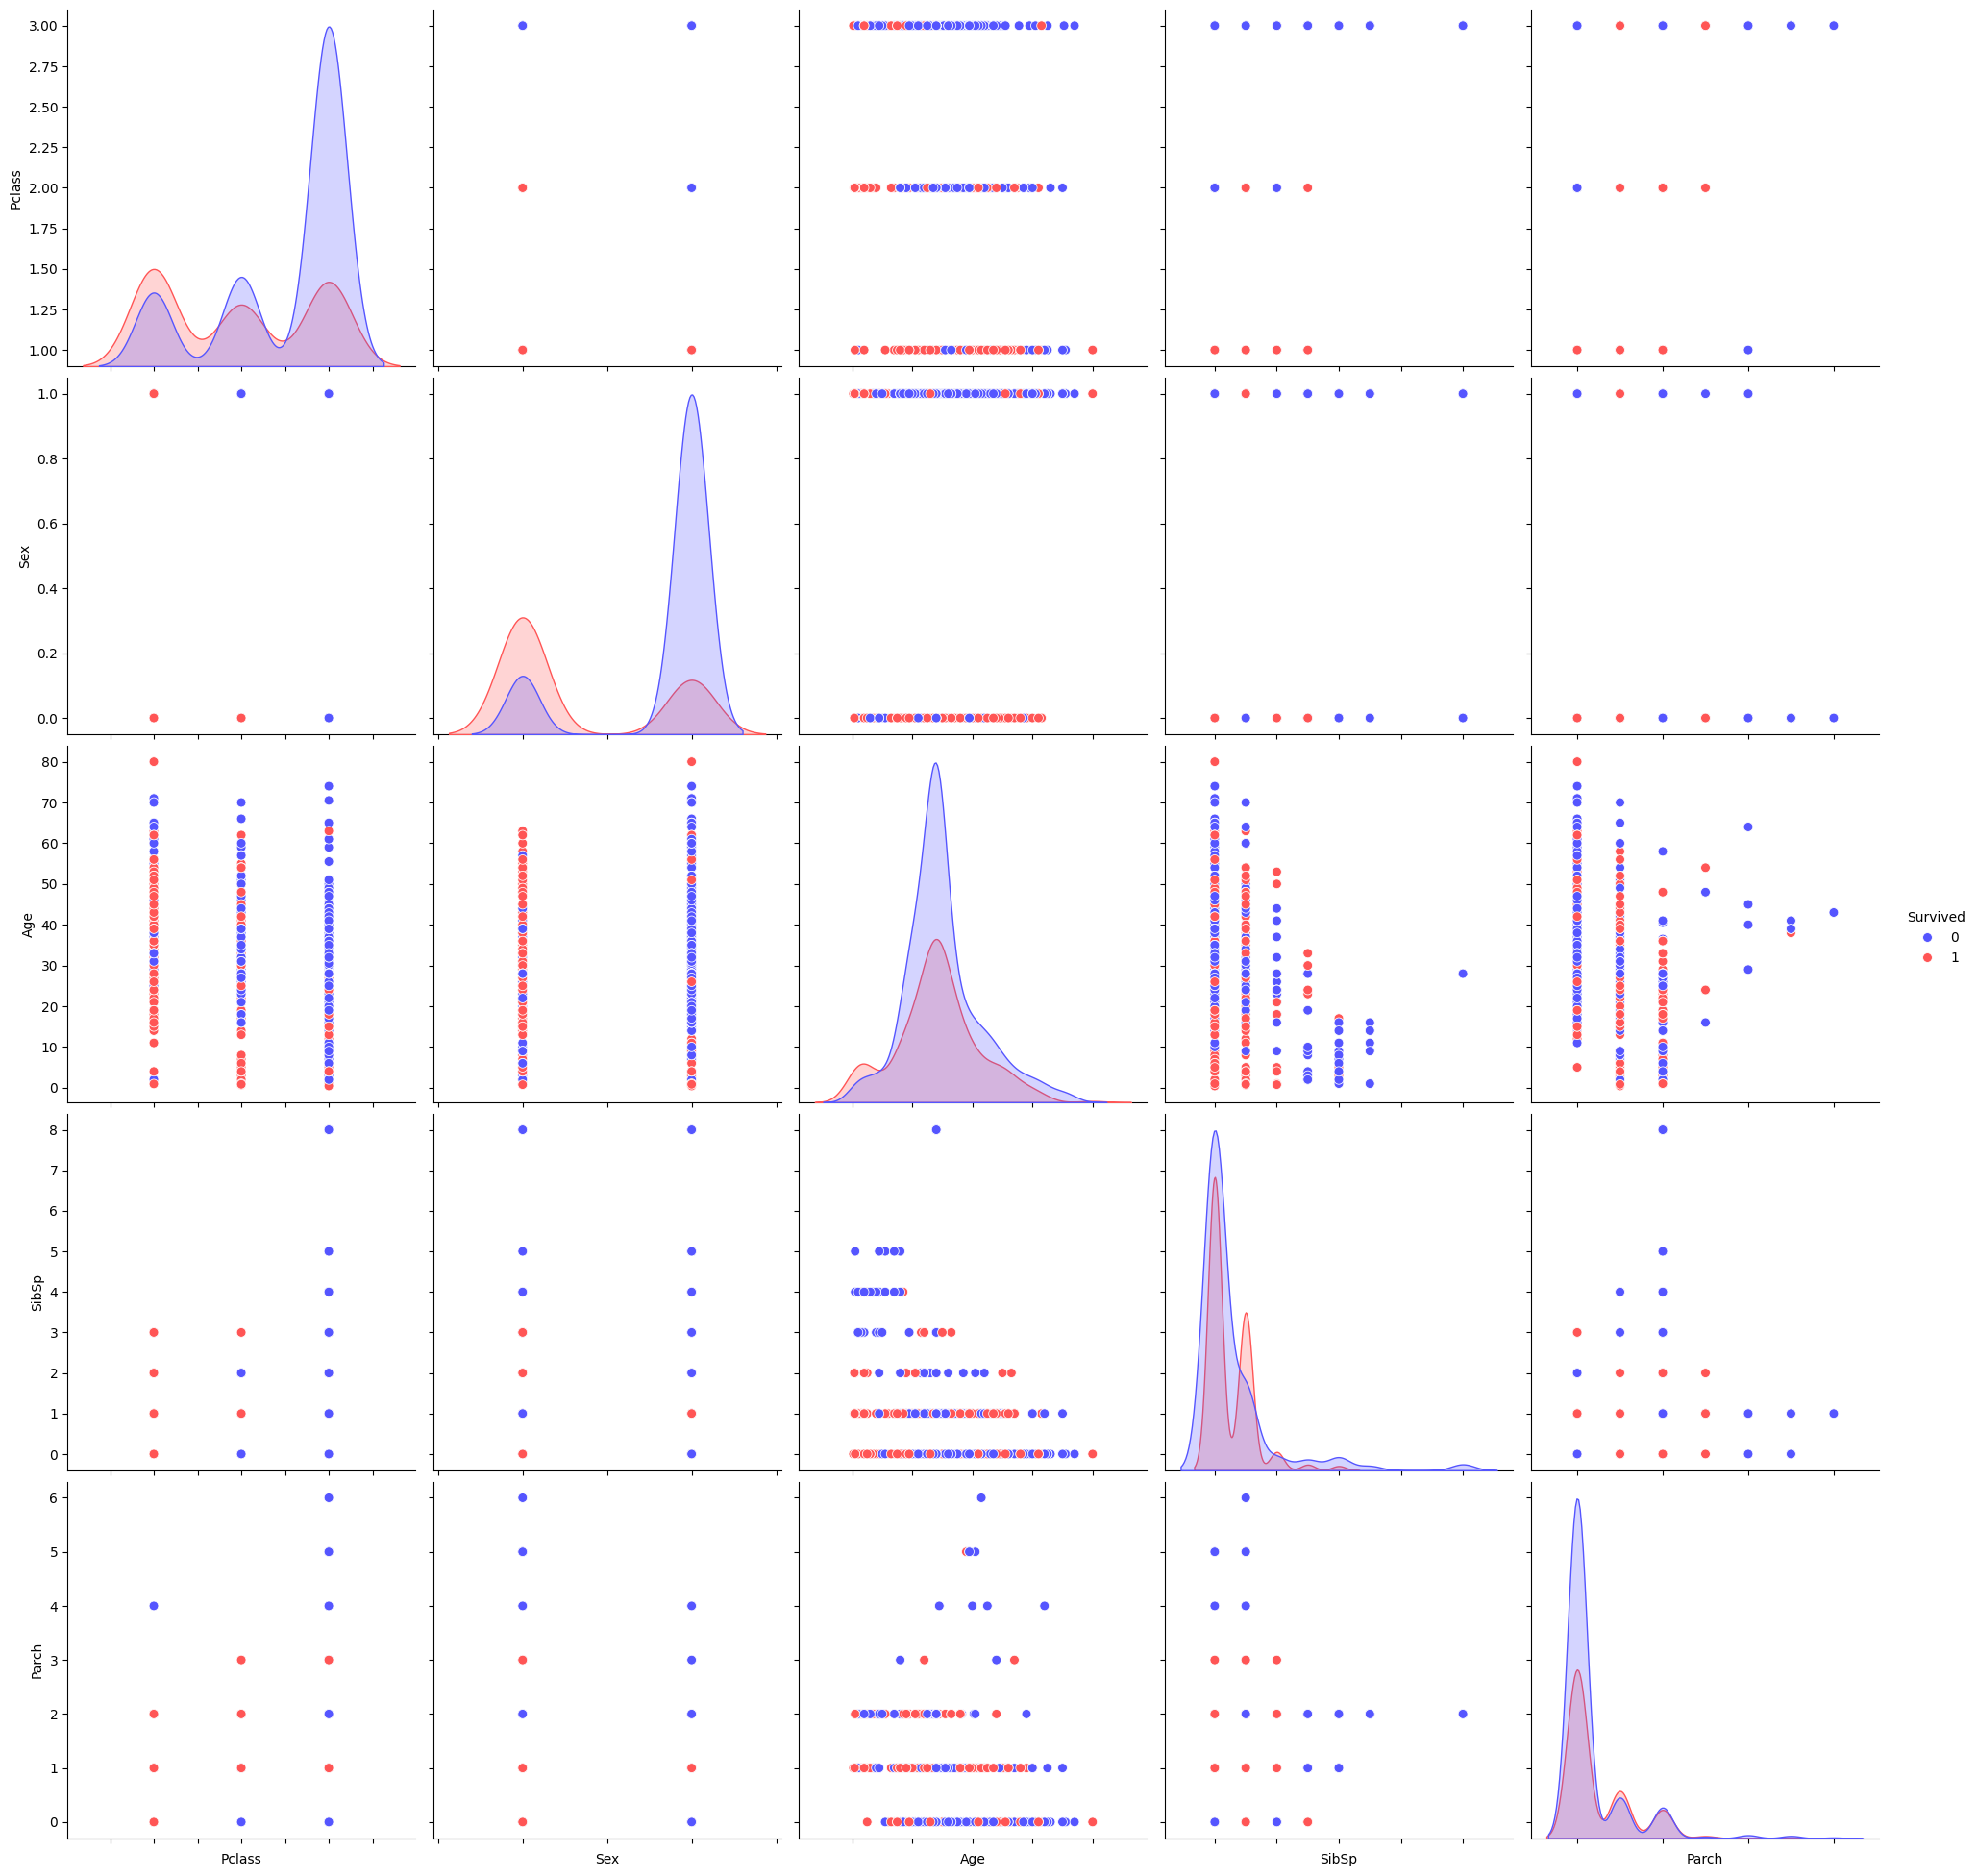

In [24]:
g = sns.pairplot(
    Data,
    hue='Survived',
    palette = 'seismic',
    height=4,
    diag_kind = 'kde',
    diag_kws=dict(fill=True),
    plot_kws=dict(s=50)
    )

g.set(xticklabels=[]);

## Бонус (не проверяется)

Мы не используем всю информацию о данных, в частности, не используем текстовые данные. Также из матрицы корреляций мы видим, что признаки `Parch` и `SibSp` слабо коррелируют с выживаемостью (`Survived`). Можно сконструировать новые признаки, чтобы решить эти вопросы.

Попробуйте сделать следующее.

1) Создайте признак `NameLen` и запишите в него длину имени (`Name`).

2) Создайте признак `FamilySize`, равный *Parch + SibSp + 1*. Зачем добавлять 1?

3) Создайте признак `IsAlone`, который показывает, путешествовал человек один или с семьей.

In [ ]:
# ваш код здесь

Посмотрите, как коррелируют новые признаки со столбцом `Survived`.

In [ ]:
# ваш код здесь

Можно извлечь и другую полезную информацию из данных путём конструирования новых признаков.

Придумайте ещё новые осмысленные признаки. Проверьте, как они коррелируют с выживаемостью.

In [ ]:
# ваш код здесь

Мы провели  однофакторный анализ данных и увидели, какие признаки сильно влияют на выживаемость, а какие нет.

Мы видим, что больше всего на выживаемость влияет пол пассажира.


### Наша собственная модель

Напишем свою модель, предсказывающую выживаемость только по признаку `Sex`.

In [ ]:
def prediction(x):
    if x.Sex == 1:
        return 0
    return 1

Посчитаем долю правильных ответов нашей модели.

In [ ]:
from sklearn.metrics import accuracy_score

pred = Data.apply(lambda x: prediction(x), axis=1)

accuracy_score(Data['Survived'], pred)